# Event Detection Via Social Media Data
----
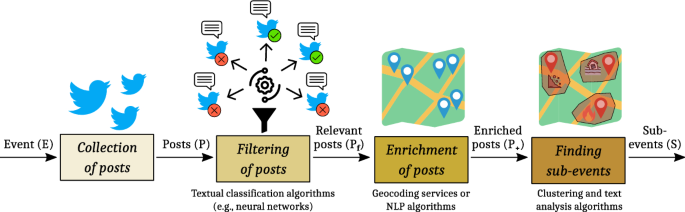

```
[Belcastro, L., Marozzo, F., Talia, D. et al. Using social media for sub-event detection during disasters. J Big Data 8, 79 (2021). https://doi.org/10.1186/s40537-021-00467-1]

```




## Table of Content

1. **Introduction**

   * Overview of the dataset
   * Purpose and objectives

2. **Background**

   * Event detection on Twitter
   * Challenges in creating event detection corpora
   * Importance of this dataset for research

3. **Dataset Overview**

   * Structure of the dataset
   * Key features (tweets, event annotations, etc.)
   * Sample data exploration

4. **Data Preprocessing**

   * Handling missing data
   * Cleaning and filtering data
   * Feature extraction and transformation

7. **Data Visualizations**

   * Graphs and plots to visualize relationships between entities, hashtags, and events
   * Network visualizations (e.g., Tweet and user interactions)

8. **Conclusion**

   * Key insights from the data analysis
   * Potential applications of event detection models
   * Next steps in research

9. **References**

   * Academic papers, tools, and methodologies used

## Introduction


---

### Introduction

In recent years, social media platforms like Twitter have emerged as rich sources of real-time information about events ranging from natural disasters and political protests to cultural trends and emergencies. This notebook presents an exploratory data analysis (EDA) on a curated dataset of tweets collected by searching custom event-related keywords.

The primary goal of this EDA is to understand the characteristics and patterns within this Twitter dataset that can aid in detecting and analyzing real-world events. We explore tweet metadata, user engagement metrics, hashtag usage, language distribution, temporal tweet patterns, and more. These insights serve as foundational knowledge for designing event detection models and developing context-aware applications.

The dataset includes tweet content, timestamps, hashtags, user information, engagement statistics, and media types. The rich annotation allows for examining trends and identifying potential signals indicative of noteworthy events.

### Background

Social media platforms like Twitter generate vast amounts of real-time data, providing insights into ongoing events around the world. However, existing corpora for event detection tasks are either too small or lack the necessary annotations for evaluating event detection systems. Many existing datasets also face issues such as geographical bias or are not designed for event-based analysis.

This dataset provides a valuable resource for researchers working on event detection systems, allowing for the development and comparison of algorithms that can detect and track events on Twitter in real time.

---

##Data Overview

In [2]:
#@title Install Packages
!pip install arabic-reshaper python-bidi
!pip install ar_wordcloud
!pip install transformers
!pip install stanza --quiet

import nltk
import stanza

nltk.download('stopwords')
from nltk.corpus import stopwords

arabic_stopwords = set(stopwords.words('arabic'))


# Download Arabic model once
stanza.download('ar', verbose=False)

# Initialize pipeline for Arabic with NER
nlp = stanza.Pipeline('ar', processors='tokenize,ner', use_gpu=True)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 292.9/292.9 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 23.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 120.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 90.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 59.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 43.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
#@title import packages
import numpy as np
import requests
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import random
import arabic_reshaper
from bidi.algorithm import get_display
import matplotlib.pyplot as plt
from collections import Counter

import matplotlib.pyplot as plt
import arabic_reshaper
from bidi.algorithm import get_display
from collections import Counter
import ast
import arabic_reshaper
from bidi.algorithm import get_display
from ar_wordcloud import ArabicWordCloud

import networkx as nx


In [4]:
#@title Sentiment Analysis Model
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

# Sentiment Analysis model (3 classes: negative, neutral, positive)
sentiment_model_name = "CAMeL-Lab/bert-base-arabic-camelbert-da-sentiment"
sentiment_tokenizer = AutoTokenizer.from_pretrained(sentiment_model_name)
sentiment_model = AutoModelForSequenceClassification.from_pretrained(sentiment_model_name)

# Map model output to labels
id2label = sentiment_model.config.id2label  # e.g., {0: 'negative', 1: 'neutral', 2: 'positive'}


# Apply sentiment analysis
def predict_sentiment(text):
    inputs = sentiment_tokenizer(text, return_tensors="pt", truncation=True, max_length=128,
        padding="max_length" )
    with torch.no_grad():
        outputs = sentiment_model(**inputs)
    prediction = torch.argmax(outputs.logits, dim=1).item()
    return id2label[prediction]
# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
sentiment_model.to(device)

def batch_predict(texts, batch_size=32):
    all_predictions = []

    for i in tqdm(range(0, len(texts), batch_size)):
        batch = texts[i:i + batch_size]

        inputs = sentiment_tokenizer(
            batch,
            return_tensors="pt",
            truncation=True,
            max_length=128,
            padding="max_length"
        ).to(device)

        with torch.no_grad():
            outputs = sentiment_model(**inputs)
            predictions = torch.argmax(outputs.logits, dim=1).cpu().numpy()
            labels = [id2label[pred] for pred in predictions]
            all_predictions.extend(labels)

    return all_predictions

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/86.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/841 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/305k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

In [5]:
#@title Hate Speech Analysis Model
# Hate Speech model (2 classes: not hate, hate)
hate_model_name = "Hate-speech-CNERG/dehatebert-mono-arabic"
hate_tokenizer = AutoTokenizer.from_pretrained(hate_model_name)
hate_model = AutoModelForSequenceClassification.from_pretrained(hate_model_name)

def batch_predict_hate(texts, batch_size=32):
    all_predictions = []

    for i in tqdm(range(0, len(texts), batch_size)):
        batch = texts[i:i + batch_size]

        inputs = hate_tokenizer(
            batch,
            return_tensors="pt",
            truncation=True,
            max_length=128,
            padding="max_length"
        ).to(device)

        with torch.no_grad():
            outputs = hate_model(**inputs)
            predictions = torch.argmax(outputs.logits, dim=1).cpu().numpy()
            all_predictions.extend(predictions)  # 0: Not Hate, 1: Hate

    return all_predictions


tokenizer_config.json:   0%|          | 0.00/152 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.23k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/872k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/669M [00:00<?, ?B/s]

In [6]:
#@title uitlities
import re

def clean_tweet(text):
    if not isinstance(text, str):
        return ''
    text = re.sub(r'http\S+', '', text)            # remove URLs
    text = re.sub(r'@\w+', '', text)                # remove mentions
    text = re.sub(r'#\w+', '', text)                # remove hashtags
    text = re.sub(r'[^ء-يa-zA-Z0-9\s]', ' ', text) # keep Arabic letters, Latin letters, numbers, and spaces only
    text = re.sub(r'\s+', ' ', text)                 # remove extra whitespace
    return text.strip()

def extract_entities_stanza(text):
    if not isinstance(text, str) or text.strip() == "":
        return []
    doc = nlp(text)
    entities = [ent.text for ent in doc.ents]
    return entities




In [7]:
# @title Define Constants
urls = [
    "https://raw.githubusercontent.com/HasanKhadd0ur/SocialED_datasets/main/npy_data/Event2012.npy"
]

columns=[ 'tweet_id', 'text', 'event_id', 'words', 'filtered_words', 'entities', 'user_id', 'created_at', 'urls', 'hashtags', 'user_mentions']

In [8]:
#@title read the data set
df = pd.read_csv("merged_output.csv")
df

model.safetensors:   0%|          | 0.00/669M [00:00<?, ?B/s]

,Tweet ID,Tweet Text,Type,Author Name,Author Username,Creation Time,Reply Count,Retweet Count,Quote Count,Like Count,View Count,Bookmark Count,Language,Possibly Sensitive,Source,Hashtags,Tweet URL,Media Type,Media URLs,External URLs
0,"=""1927874120772956317""",@mhmdfaisel وشو مشان انو الإتحاد الأوروبي يفرض...,Reply,mh ho,mhho6163,"5/29/2025, 2:46:23 AM",0,0,0,0,69.0,0,ar,No,Twitter for Android,NaN,https://x.com/mhho6163/status/1927874120772956317,NaN,NaN,NaN
1,"=""1927861544060158138""",مفارقات :\n\nالاتحاد الأوروبي يفرض عقوبات على ...,Tweet,الشاهين 🦅,Alsaheensy,"5/29/2025, 1:56:24 AM",0,0,0,0,82.0,0,ar,No,Twitter for iPhone,NaN,https://x.com/Alsaheensy/status/19278615440601...,NaN,NaN,NaN
2,"=""1927854352665805217""",هل هذا دليل أن الرئيس القادم سوف يكون العميد م...,Tweet,ROBAL SAKER,ROBALSAKER,"5/29/2025, 1:27:50 AM",0,0,0,0,189.0,1,ar,No,Twitter for iPhone,NaN,https://x.com/ROBALSAKER/status/19278543526658...,photo,https://pbs.twimg.com/media/GsEdUL5WgAA8l4N.jpg,NaN
3,"=""1927839951204368435""",@OmarMuhammadAr لم اكن اعرف انو العميد محمد ال...,Reply,Super_Syrian ,Super_Syrian,"5/29/2025, 12:30:36 AM",0,0,0,1,177.0,0,ar,No,Twitter Web App,NaN,https://x.com/Super_Syrian/status/192783995120...,NaN,NaN,NaN
4,"=""1927829497832669341""",@HuseinA73735783 @mohammad_shazar مو دفاع عن ا...,Reply,عبد الباسط المنادي,abdalpasst111,"5/28/2025, 11:49:04 PM",1,0,0,0,65.0,0,ar,No,Twitter for iPhone,NaN,https://x.com/abdalpasst111/status/19278294978...,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20285,"=""1853556021329080486""",صرنا نجددُ الحزنَ مرتينِ ..\nوفي الأربعينِ نضا...,Tweet,NaN,NaN,"11/5/2024, 12:52:47 AM",18,42,1,444,22803.0,35,ar,No,Twitter for Android,#اربعينية_سيد_المقاومة,https://x.com/undefined/status/185355602132908...,photo,https://pbs.twimg.com/media/GbknYNbWwAAVad7.jpg,NaN
20286,"=""1395796795956023296""",يوم الحداد الشركسي ( شوغة ماف ) يوم الحزن الشر...,Tweet,NaN,NaN,"5/21/2021, 8:41:03 PM",1,4,0,17,NaN,0,ar,No,Twitter for Android,#CircassianGenocide,https://x.com/undefined/status/139579679595602...,NaN,NaN,NaN
20287,"=""891310119966867457""",لم يكترث لصوت السيارات ولم يخاف لان الفقد كان ...,Tweet,NaN,NaN,"7/29/2017, 5:51:06 PM",28,98,5,83,NaN,0,ar,No,Twitter for iPhone,NaN,https://x.com/undefined/status/891310119966867457,video,https://video.twimg.com/ext_tw_video/891309978...,NaN
20288,"=""1924194532918190303""",﴿ رَوحٌ ورَيحَانٌ وجَنَّةُ نَعِيمْ ﴾\nإنّ العي...,Tweet,NaN,NaN,"5/18/2025, 11:05:01 PM",25,2,0,25,6766.0,0,ar,No,Twitter for iPhone,NaN,https://x.com/undefined/status/192419453291819...,photo,https://pbs.twimg.com/media/GrQcujhWYAEY6hY.jpg,NaN


In [9]:
#@title Data Columns
df.columns

Index(['Tweet ID', 'Tweet Text', 'Type', 'Author Name', 'Author Username',
       'Creation Time', 'Reply Count', 'Retweet Count', 'Quote Count',
       'Like Count', 'View Count', 'Bookmark Count', 'Language',
       'Possibly Sensitive', 'Source', 'Hashtags', 'Tweet URL', 'Media Type',
       'Media URLs', 'External URLs'],
      dtype='object')

In [10]:
# @title Ensure Type
# Ensure datetime format
df['Creation Time'] = pd.to_datetime(df['Creation Time'])


In [11]:
# @title Data shape
print(df.shape)


(20290, 20)


## Explore Dataset

In [ ]:
#@title Some Sampels From the Dataset
df.sample(2)

,Tweet ID,Tweet Text,Type,Author Name,Author Username,Creation Time,Reply Count,Retweet Count,Quote Count,Like Count,View Count,Bookmark Count,Language,Possibly Sensitive,Source,Hashtags,Tweet URL,Media Type,Media URLs,External URLs
6152,"=""1864992614677635267""",#عاجل | الرئيس التركي: \r\n🔴 المعارضة السورية ...,Tweet,العربي الجديد,alaraby_ar,2024-12-06 14:17:43,5,7,1,35,3112.0,1,ar,No,Twitter Web App,#عاجل,https://x.com/alaraby_ar/status/18649926146776...,photo,https://pbs.twimg.com/media/GeHI5UXW8AAaWEm.jpg,NaN
16247,"=""1925264751313015219""",@shibl91 نطالب بعزل محافظ السويداء مصطفى البكو...,Reply,011resalh,011resalh,2025-05-21 21:57:41,0,0,0,0,NaN,0,ar,No,Twitter Web App,NaN,https://x.com/011resalh/status/192526475131301...,NaN,NaN,NaN


In [12]:
#@title Clean the tweet texts
df['Old Tweet Text'] = df['Tweet Text']
df['Tweet Text'] = df['Tweet Text'].apply(clean_tweet)


In [13]:
# @title Check for missing values
# Basic DataFrame info
df.info()

# Check for missing values
print("\nMissing values per column:\n", df.isna().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20290 entries, 0 to 20289
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Tweet ID            20290 non-null  object        
 1   Tweet Text          20290 non-null  object        
 2   Type                20290 non-null  object        
 3   Author Name         13214 non-null  object        
 4   Author Username     13214 non-null  object        
 5   Creation Time       20290 non-null  datetime64[ns]
 6   Reply Count         20290 non-null  int64         
 7   Retweet Count       20290 non-null  int64         
 8   Quote Count         20290 non-null  int64         
 9   Like Count          20290 non-null  int64         
 10  View Count          20008 non-null  float64       
 11  Bookmark Count      20290 non-null  int64         
 12  Language            20290 non-null  object        
 13  Possibly Sensitive  20290 non-null  object    

In [14]:
# @title Describe the data
df.describe()

,Creation Time,Reply Count,Retweet Count,Quote Count,Like Count,View Count,Bookmark Count
count,20290,20290.000000,20290.000000,20290.000000,20290.000000,2.000800e+04,20290.000000
mean,2025-04-24 18:05:18.281912064,10.542336,15.703006,1.657516,108.846624,9.292165e+03,5.413652
min,2009-12-06 18:29:22,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000
25%,2025-05-13 22:33:41.249999872,0.000000,0.000000,0.000000,0.000000,4.200000e+01,0.000000
50%,2025-05-20 11:58:57.500000,0.000000,0.000000,0.000000,1.000000,1.420000e+02,0.000000
75%,2025-05-24 20:47:30.500000,1.000000,1.000000,0.000000,10.000000,8.060000e+02,0.000000
max,2025-05-31 22:10:26,19007.000000,13406.000000,2208.000000,46436.000000,6.139862e+06,2906.000000
std,NaN,177.464351,187.080565,21.752436,810.770100,8.645787e+04,49.874810


In [15]:
# @title The Range of the data
print(df["Creation Time"].min(), df["Creation Time"].max())

2009-12-06 18:29:22 2025-05-31 22:10:26


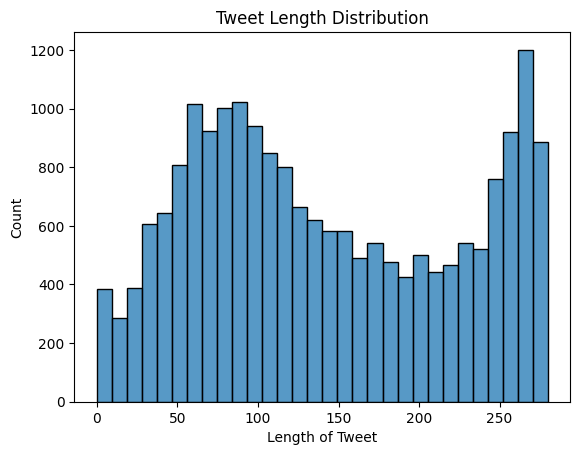

In [16]:
#@title Tweet length distribution
df['text_length'] = df['Tweet Text'].apply(len)
# df['text_length'].describe()

# Plot distribution
# plt.figure(figsize=(10, 6))
# sns.histplot(df['text_length'], bins=30, kde=True, color='skyblue')
# plt.title('Distribution of Tweet Lengths')
# plt.xlabel('Tweet Length')
# plt.ylabel('Frequency')
# plt.grid(True)
# plt.show()
sns.histplot(df['text_length'], bins=30)
plt.title('Tweet Length Distribution')
plt.xlabel('Length of Tweet')
plt.ylabel('Count')
plt.show()

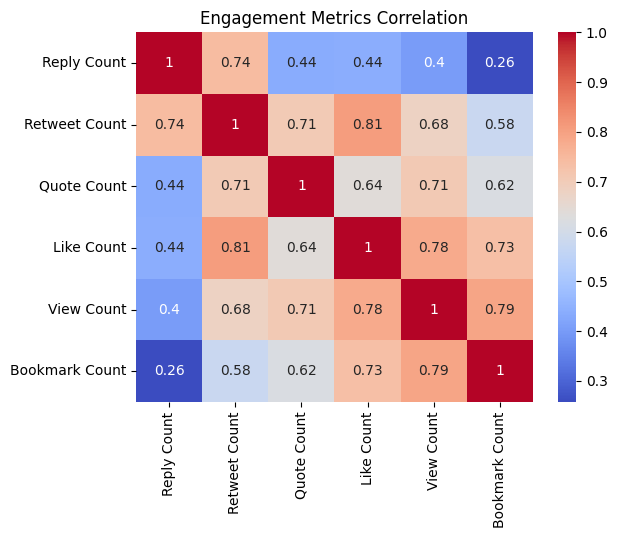

In [17]:
#@title Correlation Heat Map
engagement_cols = ['Reply Count', 'Retweet Count', 'Quote Count', 'Like Count', 'View Count', 'Bookmark Count']
df[engagement_cols].describe()

# Correlation heatmap
sns.heatmap(df[engagement_cols].corr(), annot=True, cmap='coolwarm')
plt.title('Engagement Metrics Correlation')
plt.show()


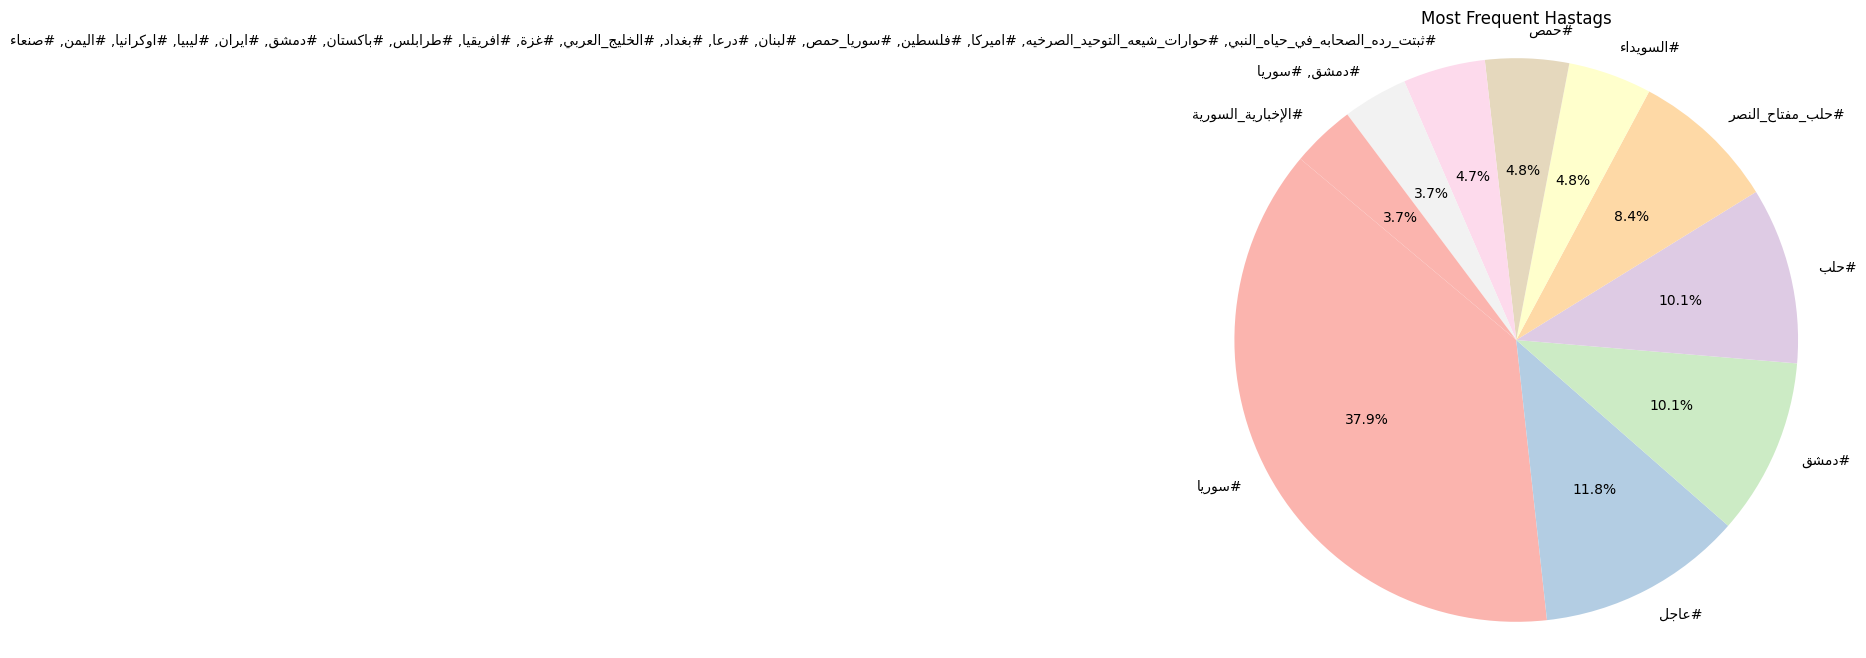

In [18]:
#@title Frequent Hashtags
# Prepare hashtag counts
all_hashtags = df['Hashtags'].dropna().apply(lambda x: ast.literal_eval(x) if isinstance(x, str) and x.startswith('[') else [x])
flattened = [tag for sublist in all_hashtags for tag in sublist]
hashtag_counts = Counter(flattened)

# Extract top 10 hashtags
top_hashtags = hashtag_counts.most_common(10)
labels, counts = zip(*top_hashtags)

# Reshape and reorder Arabic labels
reshaped_labels = [get_display(arabic_reshaper.reshape(label)) for label in labels]

# Plot pie chart
plt.figure(figsize=(8, 8))
plt.pie(counts, labels=reshaped_labels, autopct='%1.1f%%', startangle=140, colors=plt.cm.Pastel1.colors)
plt.title("Most Frequent Hastags")
plt.axis('equal')  # Equal aspect ratio ensures pie is circular.
plt.show()


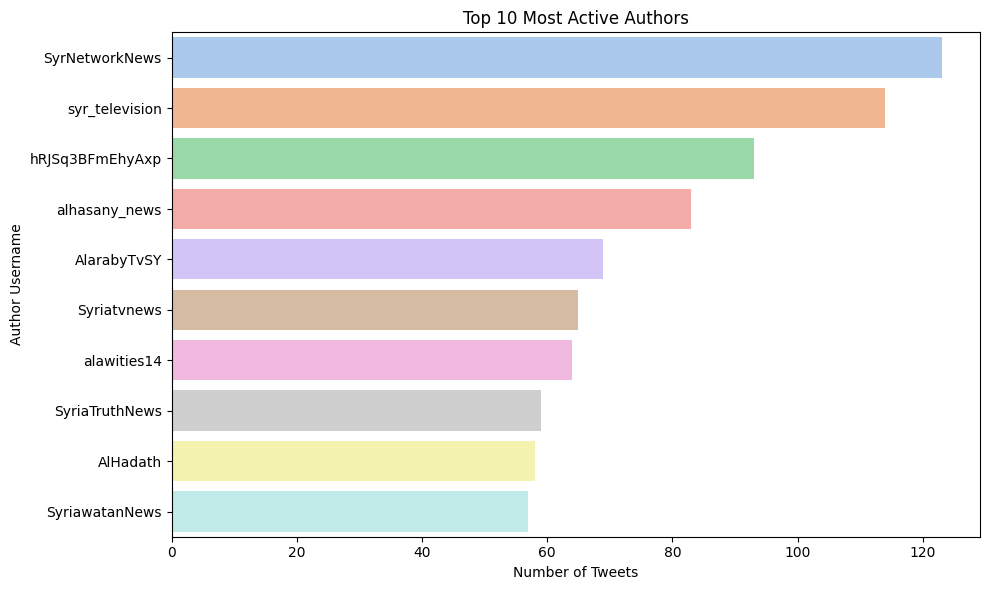

In [ ]:
# @title Most active authors

top_authors = df['Author Username'].value_counts().head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_authors.values, y=top_authors.index, palette='pastel',hue=top_authors.index)
plt.title('Top 10 Most Active Authors')
plt.xlabel('Number of Tweets')
plt.ylabel('Author Username')
plt.tight_layout()
plt.show()

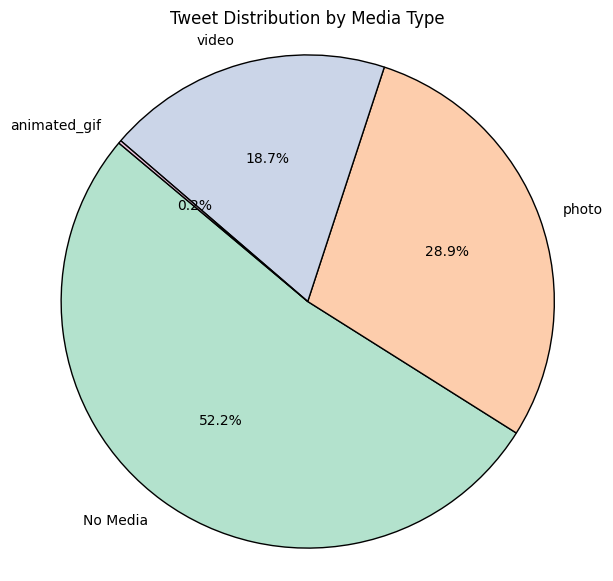

In [19]:
#@title Media Type
import matplotlib.pyplot as plt

# Get media type counts including NaNs
media_counts = df['Media Type'].value_counts(dropna=False)

# Replace NaN label with 'No Media'
media_counts.index = media_counts.index.fillna('No Media')

plt.figure(figsize=(7,7))
plt.pie(
    media_counts,
    labels=media_counts.index,
    autopct='%1.1f%%',
    startangle=140,
    colors=plt.cm.Pastel2.colors,
    wedgeprops={'edgecolor': 'black'}
)
plt.title('Tweet Distribution by Media Type')
plt.axis('equal')
plt.show()



In [20]:
#@title External URLs presence
ext_urls=df['External URLs'].notnull().sum()
print(f"Number of tweets with external URLs: {ext_urls}")

Number of tweets with external URLs: 1479


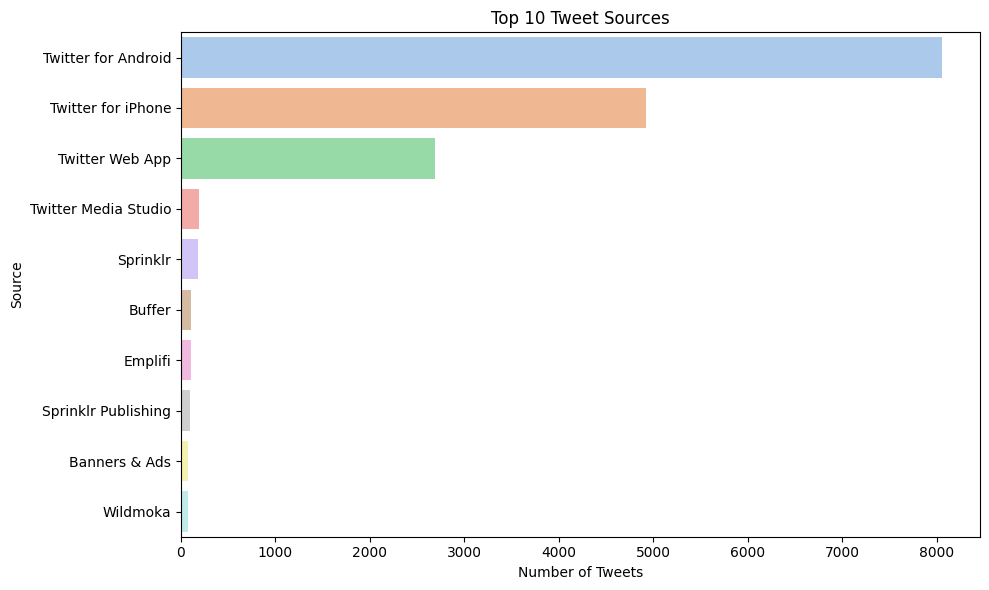

In [ ]:

#@title Most common sources (devices/apps used)

# Get top 10 sources
top_sources = df['Source'].value_counts().head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_sources.values, y=top_sources.index, palette='pastel',hue=top_sources.index)
plt.title('Top 10 Tweet Sources')
plt.xlabel('Number of Tweets')
plt.ylabel('Source')
plt.tight_layout()
plt.show()

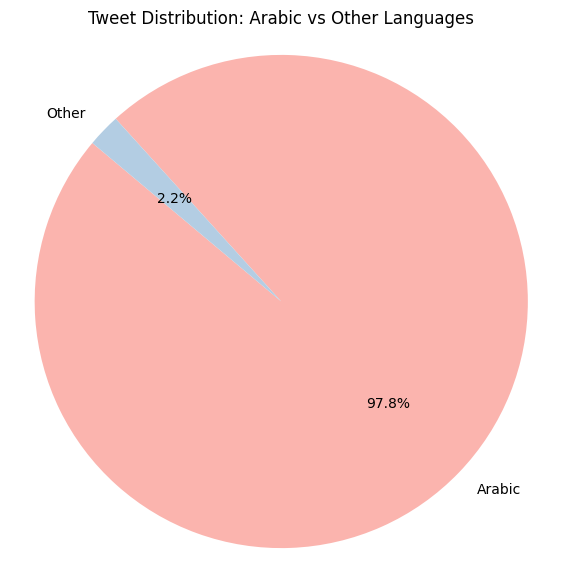

In [21]:
#@title Languages Distribution
# Count languages
language_counts = df['Language'].value_counts()

arabic_lang = 'ar'  # change if needed
arabic_count = language_counts.get(arabic_lang, 0)

# Sum of all non-Arabic languages
other_count = language_counts.sum() - arabic_count

# Create series for pie chart
pie_counts = [arabic_count, other_count]
labels = ['Arabic', 'Other']

# Plot pie chart
plt.figure(figsize=(7,7))
plt.pie(pie_counts, labels=labels, autopct='%1.1f%%', startangle=140, colors=plt.cm.Pastel1.colors)
plt.title('Tweet Distribution: Arabic vs Other Languages')
plt.axis('equal')  # Make pie circular
plt.show()


In [30]:
# @title Remove  Duplicate Tweets

# Show original shape
print(f"Original shape: {df.shape}")

# Drop duplicate tweets based on the 'Tweet Text' column (case-sensitive)
df = df.drop_duplicates(subset='Tweet Text').reset_index(drop=True)

# Show new shape
print(f"Shape after removing duplicates: {df.shape}")


Original shape: (20290, 24)
Shape after removing duplicates: (17156, 24)


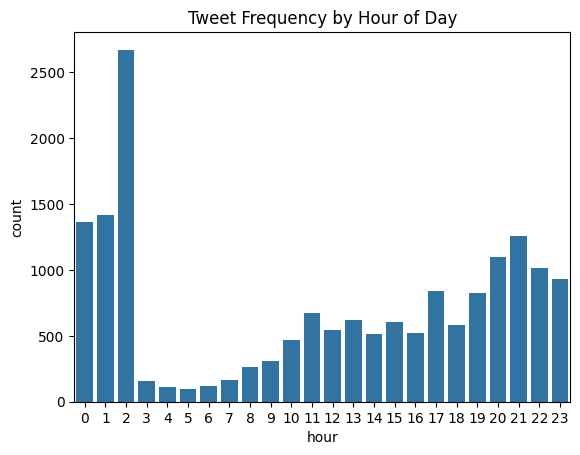

In [31]:
# @title Tweet Frequency by Hour
# Extract hour and date
df['hour'] = df['Creation Time'].dt.hour
df['date'] = df['Creation Time'].dt.date

# Plot tweet frequency by hour
sns.countplot(x='hour', data=df)
plt.title('Tweet Frequency by Hour of Day')
plt.show()


<ipython-input-32-2e1a0f503a1e>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  day_df['Word Count'] = day_df['Tweet Text'].str.split().apply(len)


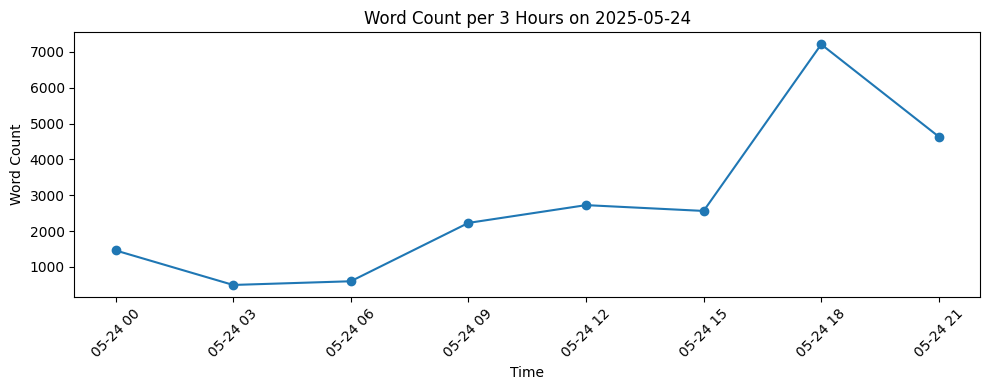

In [32]:
# @title Word Count per 3 Hours on A Day
# Select a specific date (e.g., May 21, 2025)
selected_day = '2025-05-24'
day_df = df[df['Creation Time'].dt.date == pd.to_datetime(selected_day).date()]

# Create a new column with word count
day_df['Word Count'] = day_df['Tweet Text'].str.split().apply(len)

# Set datetime index to resample
day_df = day_df.set_index('Creation Time')

# Resample every 3 hours and sum word counts
word_counts_3h = day_df['Word Count'].resample('3h').sum()

# Plot
plt.figure(figsize=(10, 4))
plt.plot(word_counts_3h.index, word_counts_3h.values, marker='o')
plt.title(f'Word Count per 3 Hours on {selected_day}')
plt.xlabel('Time')
plt.ylabel('Word Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

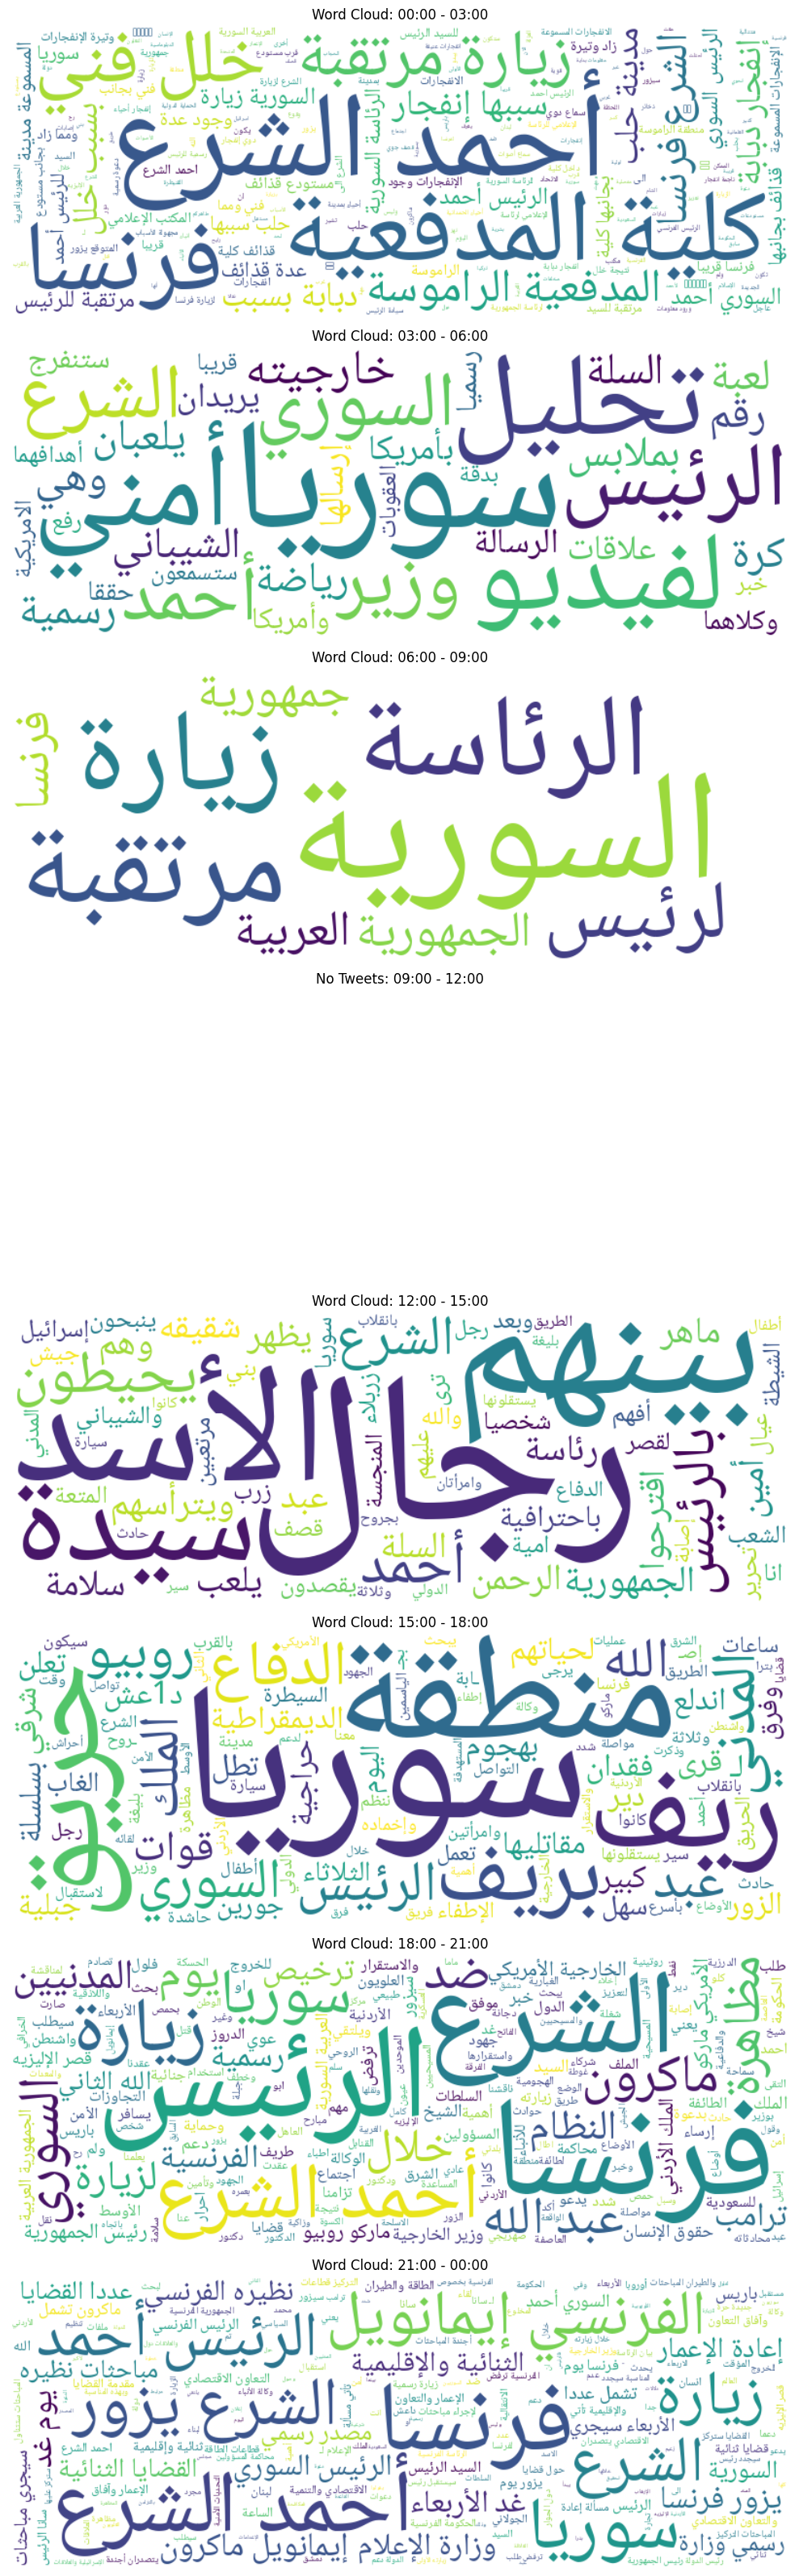

In [33]:
#@title  word cloud for a day
# Filter tweets for the selected day first
selected_day = '2025-05-06'
day_df = df[df['Creation Time'].dt.date == pd.to_datetime(selected_day).date()].copy()
day_df = day_df.set_index('Creation Time')

# Resample every 3 hours
intervals = list(day_df.resample('3h'))

# Create subplots
fig, axs = plt.subplots(len(intervals), 1, figsize=(10, 4 * len(intervals)))
if len(intervals) == 1:
    axs = [axs]

for i, (time_bin, group) in enumerate(intervals):
    # Join all tweet texts into one string
    all_text = ' '.join(group['Tweet Text'].dropna().astype(str))

    if all_text.strip():
        # Remove stop words
        words = all_text.split()
        filtered_words = [w for w in words if w not in arabic_stopwords]
        filtered_text = ' '.join(filtered_words)

        # Generate Arabic word cloud
        wc = ArabicWordCloud(
            width=800,
            height=300,
            background_color='white'
        ).generate(filtered_text)

        axs[i].imshow(wc, interpolation='bilinear')
        axs[i].axis('off')
        axs[i].set_title(f'Word Cloud: {time_bin.strftime("%H:%M")} - {(time_bin + pd.Timedelta(hours=3)).strftime("%H:%M")}')
    else:
        axs[i].axis('off')
        axs[i].set_title(f'No Tweets: {time_bin.strftime("%H:%M")} - {(time_bin + pd.Timedelta(hours=3)).strftime("%H:%M")}')

plt.tight_layout()
plt.show()


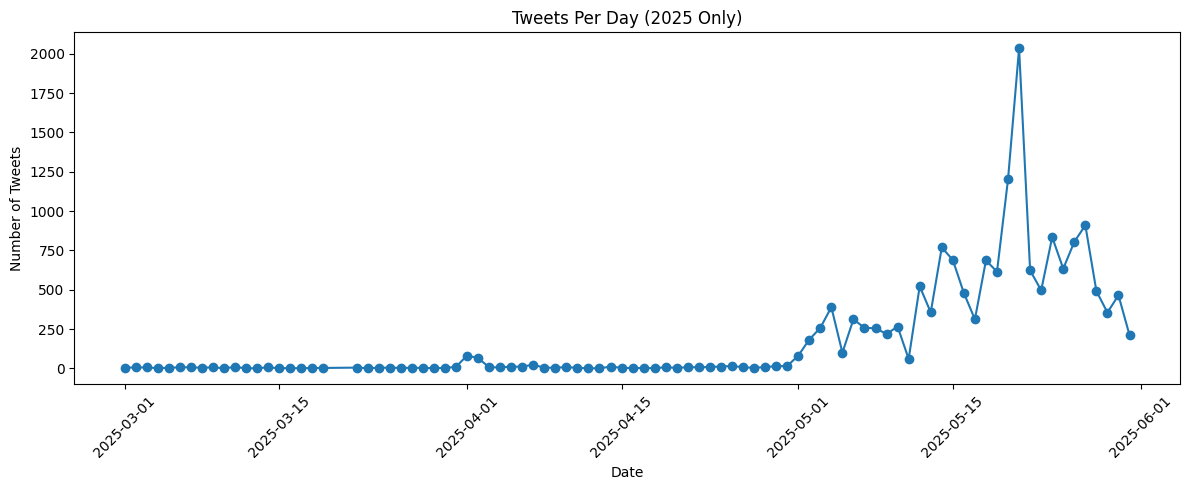

In [35]:
#@title Tweets Per Day

# Ensure 'date' column is of type Timestamp
df['date'] = pd.to_datetime(df['date'])

# Filter only tweets from 2025 onwards
df_filtered = df[df['date'] >= pd.Timestamp('2025-3-01')]

# Count tweets per day
daily_counts = df_filtered['date'].value_counts().sort_index()

# Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(daily_counts.index, daily_counts.values, marker='o')
plt.title('Tweets Per Day (2025 Only)')
plt.xlabel('Date')
plt.ylabel('Number of Tweets')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


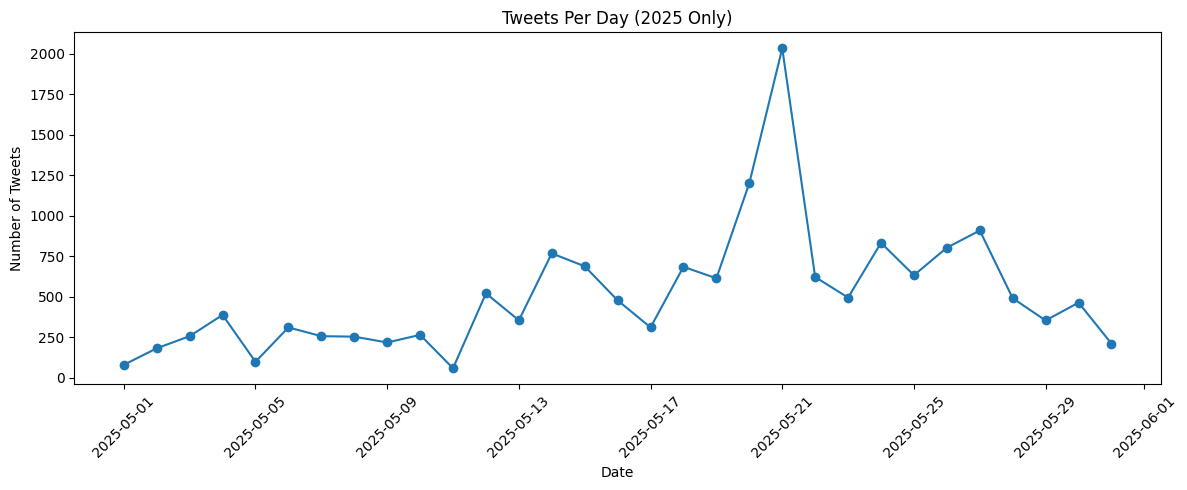

In [36]:
#@title Tweets on May 2025

# Ensure 'date' column is of type Timestamp
df['date'] = pd.to_datetime(df['date'])

# Filter only tweets from 2025 onwards
df_filtered = df[df['date'] >= pd.Timestamp('2025-5-01')]

# Count tweets per day
daily_counts = df_filtered['date'].value_counts().sort_index()

# Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(daily_counts.index, daily_counts.values, marker='o')
plt.title('Tweets Per Day (2025 Only)')
plt.xlabel('Date')
plt.ylabel('Number of Tweets')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


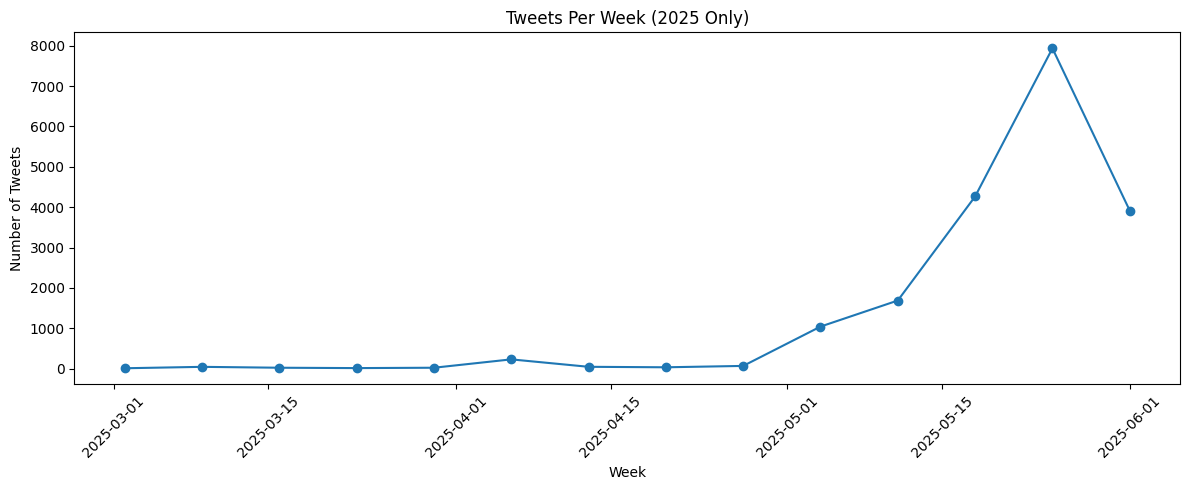

In [29]:
# @title Tweets Per Week
# Filter only tweets from 2025
df_filtered = df[df['date'] >= pd.Timestamp('2025-03-01')]

# Set 'date' as index for resampling
df_filtered = df_filtered.set_index('date')

# Group by week and count tweets
weekly_counts = df_filtered.resample('W').size()

# Plot
plt.figure(figsize=(12, 5))
plt.plot(weekly_counts.index, weekly_counts.values, marker='o')
plt.title('Tweets Per Week (2025 Only)')
plt.xlabel('Week')
plt.ylabel('Number of Tweets')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


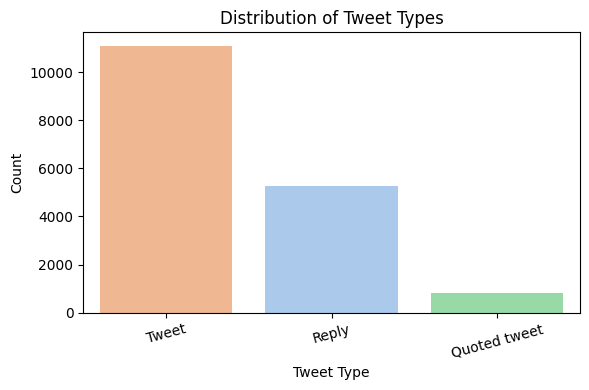

In [37]:
#@title Tweets Type
# Count plot for 'Type'
plt.figure(figsize=(6, 4))
sns.countplot(
    data=df,
    x='Type',
    order=df['Type'].value_counts().index,
    palette='pastel',
    hue='Type',
    legend=False
)

plt.title('Distribution of Tweet Types')
plt.xlabel('Tweet Type')
plt.ylabel('Count')
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

In [ ]:
#@title Perdicate Sentiment
# df['Sentiment'] = df['Tweet Text'].apply(predict_sentiment)

df['Sentiment'] = batch_predict(df['Tweet Text'].tolist(), batch_size=32)


100%|██████████| 312/312 [1:06:01<00:00, 12.70s/it]


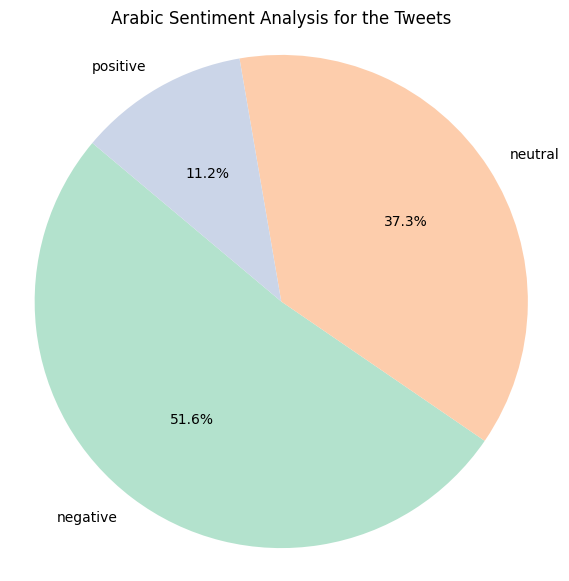

In [ ]:

# @title Plot sentiment distribution
sentiment_counts = df['Sentiment'].value_counts()
labels = sentiment_counts.index.tolist()
counts = sentiment_counts.values.tolist()

# Plot
plt.figure(figsize=(7, 7))
plt.pie(counts, labels=labels, autopct='%1.1f%%', startangle=140, colors=plt.cm.Pastel2.colors)
plt.title("Arabic Sentiment Analysis for the Tweets")
plt.axis('equal')
plt.show()

In [ ]:
#@title Hate Speech Detection
df['HateSpeech'] = batch_predict_hate(df['Tweet Text'].tolist(), batch_size=64)

100%|██████████| 156/156 [1:10:26<00:00, 27.09s/it]


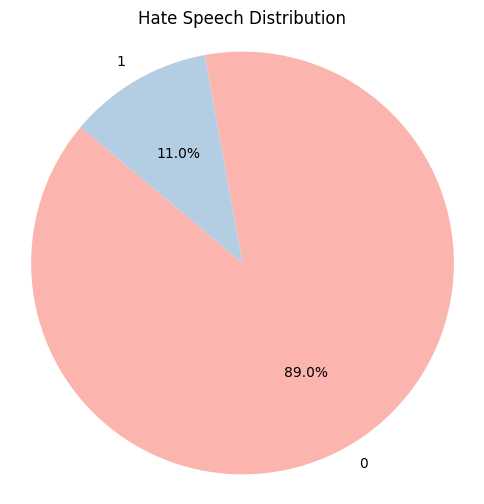

In [ ]:
#@title Hate Speach Distribution
counts = df['HateSpeech'].value_counts()
plt.figure(figsize=(6, 6))
plt.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=140, colors=plt.cm.Pastel1.colors)
plt.title("Hate Speech Distribution")
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()


In [ ]:
#@title Extract Named Entites
from concurrent.futures import ThreadPoolExecutor

# Use ThreadPool to speed up processing
texts = df['Tweet Text'].tolist()

with ThreadPoolExecutor(max_workers=8) as executor:
    named_entities = list(executor.map(extract_entities_stanza, texts))

df['Named Entities'] = named_entities


In [ ]:
#@title Some Named Entities
df['Named Entities'].sample(4)

,Named Entities
2545,"[الدانا, إدلب, #سوريا]"
4571,"[#تلفزيون_سوريا, _سوريا]"
6239,"[دمشق, سوريا, موانئ دبي العالمية, دي بي ورلد, ..."
8792,"[الشولا, دير الزور, تدمر]"


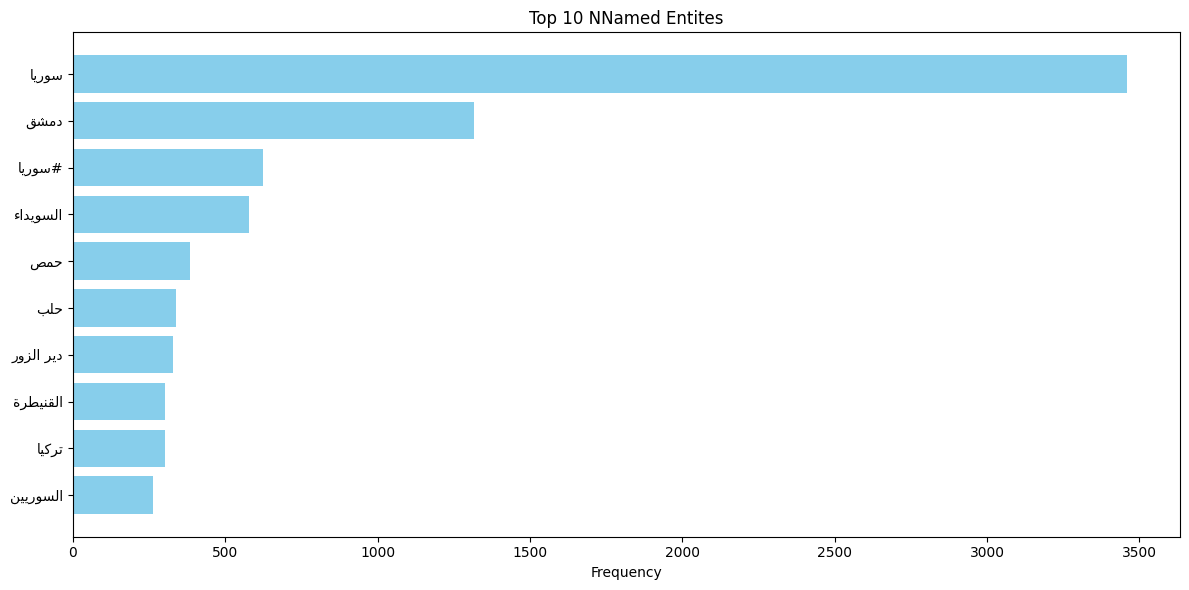

In [ ]:
#@title Top Named Entities
# Flatten all named entities from the dataframe column into a single list
all_entities = [ent for sublist in df['Named Entities'] for ent in sublist]

# Count frequency of each entity
entity_counts = Counter(all_entities)

# Get top 10 entities and their counts
top_entities = entity_counts.most_common(10)
entities, counts = zip(*top_entities)

# Reshape and reorder Arabic entity labels for correct display
reshaped_entities = [get_display(arabic_reshaper.reshape(ent)) for ent in entities]

# Plot bar chart
plt.figure(figsize=(12, 6))
plt.barh(reshaped_entities[::-1], counts[::-1], color='skyblue')  # reversed for descending order
plt.xlabel('Frequency')
plt.title("Top 10 NNamed Entites")
plt.tight_layout()
plt.show()


مصادر محلية: انفجار داخل مقر للأمن العام السوري في بلدة الجلاء بريف مدينة البوكمال بديرالزور

قتل 3 من عناصر الامن العام واصابة 4 آخرين بحصيلة اولية للانفجار
#سوريا #دمشق #دير_الزور #البوكمال https://t.co/k3P03fbNu9


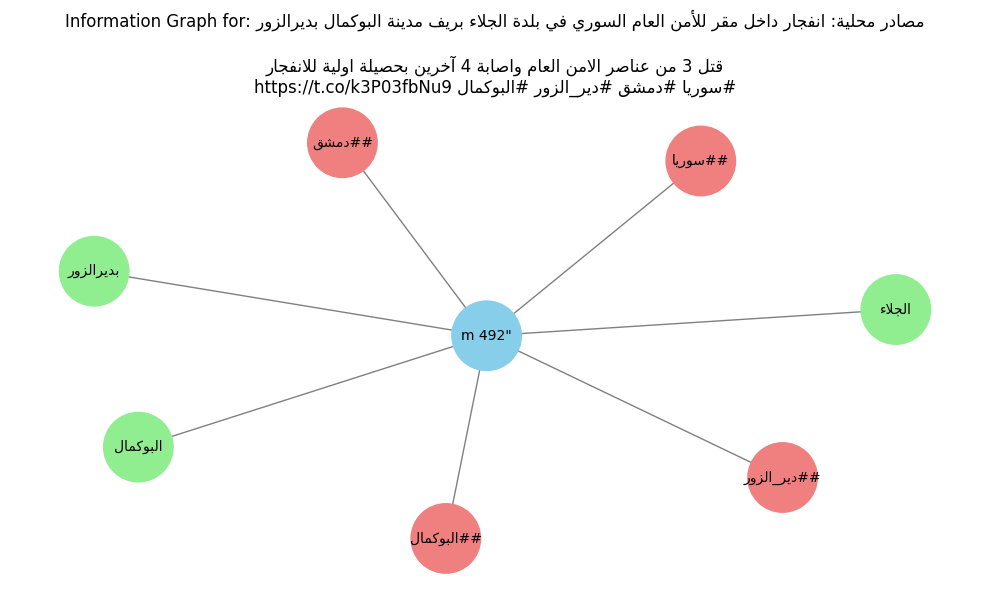

In [ ]:
#@title Message Attribute Graph
import networkx as nx
import matplotlib.pyplot as plt
import random
import arabic_reshaper
from bidi.algorithm import get_display

# Choose a single tweet randomly from your dataframe
random.seed(22)
random_idx = random.choice(df.index)
row = df.loc[random_idx]
print(row["Tweet Text"])
# Determine the entity column name
if 'Named Entities' in df.columns:
    entity_col = 'Named Entities'
elif 'entities' in df.columns:
    entity_col = 'entities'
else:
    raise ValueError("No entity column found; please check your dataframe")

G = nx.Graph()

# Create node for the tweet
tweet_node = f"m {str(row['Tweet ID'])[-4:]}"  # last 4 chars of Tweet ID
G.add_node(tweet_node, label='tweet', color='skyblue')

# Add entity nodes and edges
entities = row.get(entity_col, [])
if not isinstance(entities, list):
    entities = []

for entity in entities:
    if isinstance(entity, (tuple, list)):
        entity_text = str(entity[0]).strip()
    else:
        entity_text = str(entity).strip()

    # Reshape and reorder Arabic text for correct display
    reshaped_text = arabic_reshaper.reshape(entity_text)
    display_text = get_display(reshaped_text)

    G.add_node(display_text, label='entity', color='lightgreen')
    G.add_edge(tweet_node, display_text)

# Add hashtag nodes and edges
hashtags = row.get('Hashtags', [])
if not isinstance(hashtags, list):
    if isinstance(hashtags, str):
        if ',' in hashtags:
            hashtags = [h.strip() for h in hashtags.split(',') if h.strip()]
        else:
            hashtags = [h.strip() for h in hashtags.split() if h.strip()]
    else:
        hashtags = []

for hashtag in hashtags:
    hashtag_text = f"#{hashtag.strip().lower()}"
    reshaped_text = arabic_reshaper.reshape(hashtag_text)
    display_text = get_display(reshaped_text)

    G.add_node(display_text, label='hashtag', color='lightcoral')
    G.add_edge(tweet_node, display_text)

# Plotting the graph
pos = nx.spring_layout(G, seed=42)
node_colors = [data['color'] for _, data in G.nodes(data=True)]

plt.figure(figsize=(10, 6))
nx.draw_networkx(
    G, pos,
    with_labels=True,
    node_color=node_colors,
    font_size=10,
    node_size=2500,
    edge_color='gray'
)
plt.title(f"Information Graph for: {get_display(arabic_reshaper.reshape(row['Tweet Text']))}")
plt.axis('off')
plt.tight_layout()
plt.show()


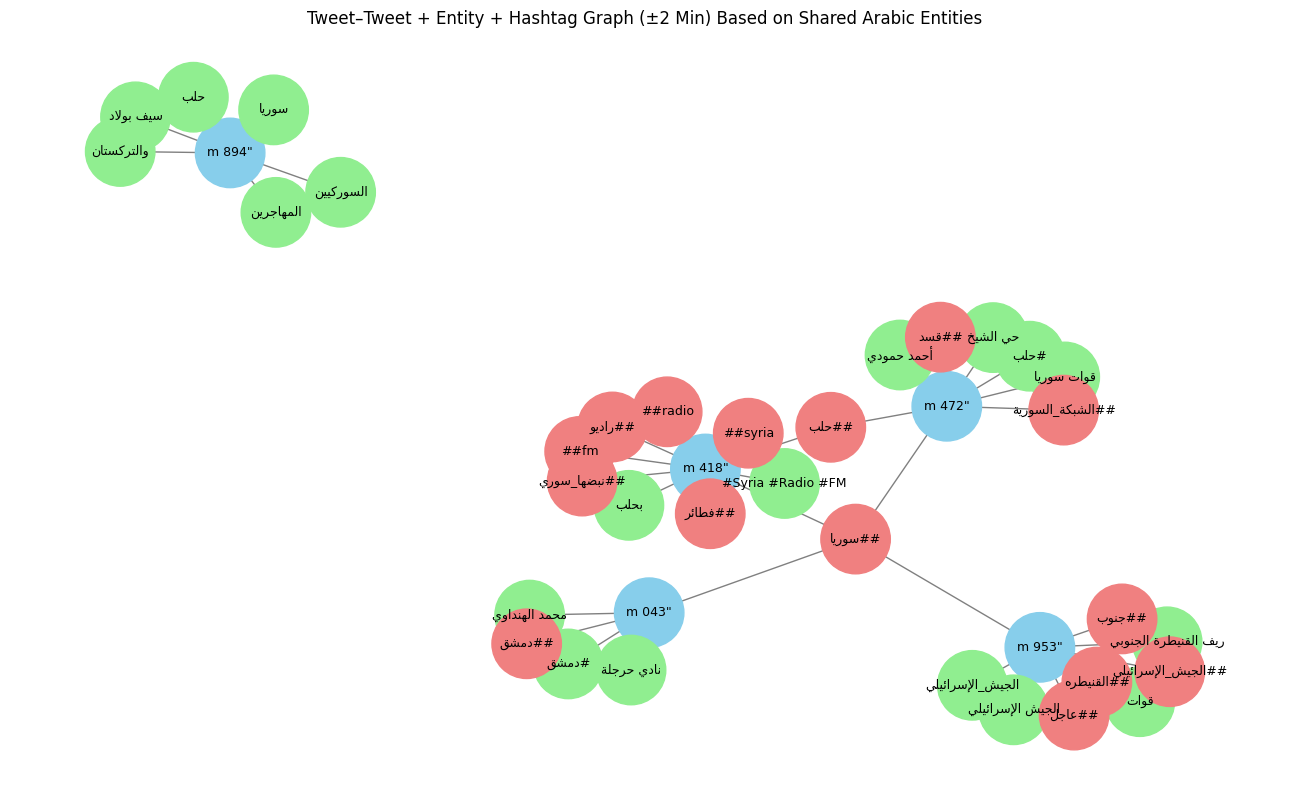

In [ ]:
#@title Social Message Graph for Messages in the Same Time Window
import networkx as nx
import matplotlib.pyplot as plt
import random
import arabic_reshaper
from bidi.algorithm import get_display
import pandas as pd

# Step 2: Randomly pick a base tweet and its creation time
random.seed(42)
base_tweet = df.sample(1).iloc[0]
base_time = base_tweet['Creation Time']

# Step 3: Get tweets within ±2 minutes of the base tweet
time_window = pd.Timedelta(minutes=100)
df_subset = df[(df['Creation Time'] >= base_time - time_window) &
               (df['Creation Time'] <= base_time + time_window)]

# Step 4: Sample up to 5 tweets from the subset
df_subset = df_subset.sample(n=min(5, len(df_subset)), random_state=42)

# Initialize graph
G = nx.Graph()
tweet_entities = {}

# Step 5: Create tweet nodes and collect reshaped entities and hashtags
for _, row in df_subset.iterrows():
    tweet_id = str(row['Tweet ID'])
    tweet_node = f"m {tweet_id[-4:]}"  # Last 4 characters
    G.add_node(tweet_node, label='tweet', color='skyblue')

    # --- Named Entities ---
    entities_raw = row.get('Named Entities') or row.get('entities', [])
    if not isinstance(entities_raw, list):
        entities_raw = []

    reshaped_entities = set()
    for ent in entities_raw:
        if isinstance(ent, (list, tuple)):
            text = str(ent[0]).strip()
        else:
            text = str(ent).strip()

        reshaped = get_display(arabic_reshaper.reshape(text))
        reshaped_entities.add(reshaped.lower())

        G.add_node(reshaped, label='entity', color='lightgreen')
        G.add_edge(tweet_node, reshaped)

    # Save for tweet-tweet edge comparison
    tweet_entities[tweet_node] = reshaped_entities

    # --- Hashtags ---
    hashtags_raw = row.get('Hashtags', [])
    if isinstance(hashtags_raw, str):
        if ',' in hashtags_raw:
            hashtags_raw = [h.strip() for h in hashtags_raw.split(',') if h.strip()]
        else:
            hashtags_raw = [h.strip() for h in hashtags_raw.split() if h.strip()]
    elif not isinstance(hashtags_raw, list):
        hashtags_raw = []

    for ht in hashtags_raw:
        ht_text = f"#{ht.strip().lower()}"
        reshaped_ht = get_display(arabic_reshaper.reshape(ht_text))
        G.add_node(reshaped_ht, label='hashtag', color='lightcoral')
        G.add_edge(tweet_node, reshaped_ht)

# Step 6: Add edges between tweets sharing at least one entity
tweet_nodes = list(tweet_entities.keys())
for i in range(len(tweet_nodes)):
    for j in range(i + 1, len(tweet_nodes)):
        t1, t2 = tweet_nodes[i], tweet_nodes[j]
        shared = tweet_entities[t1].intersection(tweet_entities[t2])
        if shared:
            G.add_edge(t1, t2, shared_entities=', '.join(shared))

# Step 7: Draw the tweet–tweet + entity + hashtag graph
pos = nx.spring_layout(G, seed=42)
node_colors = [data['color'] for _, data in G.nodes(data=True)]

plt.figure(figsize=(13, 8))
nx.draw_networkx(
    G, pos,
    with_labels=True,
    node_color=node_colors,
    font_size=9,
    node_size=2500,
    edge_color='gray'
)
plt.title("Tweet–Tweet + Entity + Hashtag Graph (±2 Min) Based on Shared Arabic Entities")
plt.axis('off')
plt.tight_layout()
plt.show()


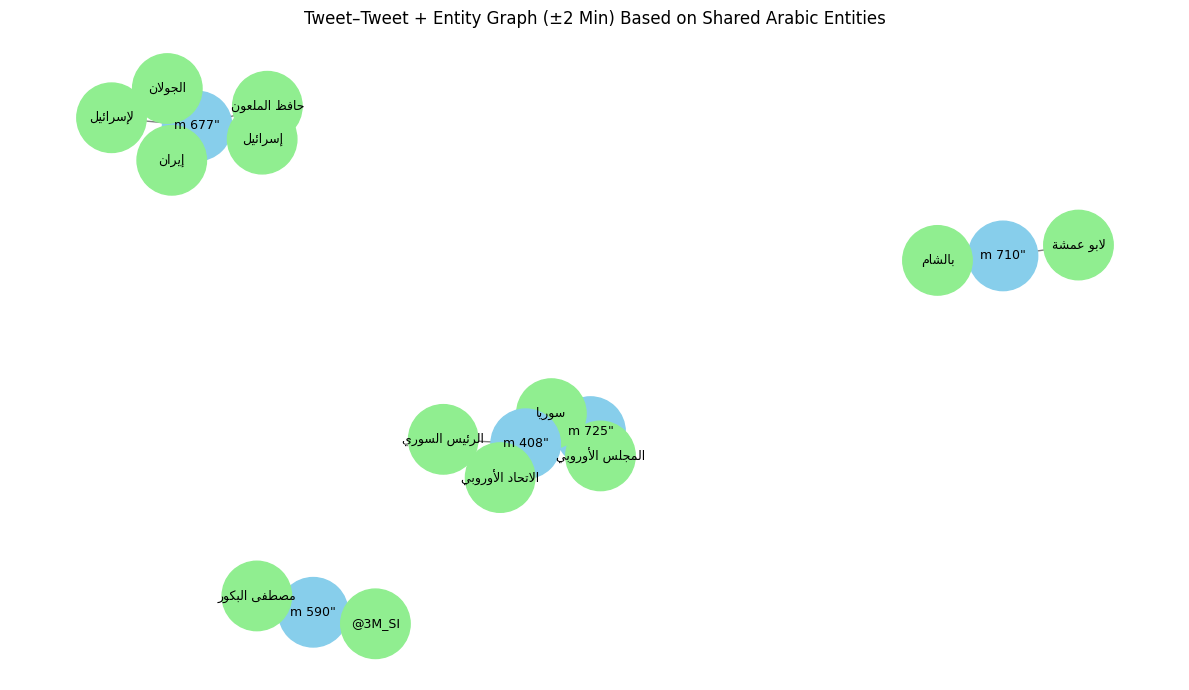

In [ ]:
#@title Social Message Graph for messages in the  Same Time
import networkx as nx
import matplotlib.pyplot as plt
import random
import arabic_reshaper
from bidi.algorithm import get_display
import pandas as pd

# Step 2: Randomly pick a base tweet and its creation time
random.seed(42)
base_tweet = df.sample(1).iloc[0]
base_time = base_tweet['Creation Time']

# Step 3: Get 5 tweets within ±2 minutes of the base tweet
time_window = pd.Timedelta(minutes=2)
df_subset = df[(df['Creation Time'] >= base_time - time_window) &
               (df['Creation Time'] <= base_time + time_window)]

# Step 4: Sample 5 tweets from the subset
df_subset = df_subset.sample(n=min(5, len(df_subset)), random_state=42)

# Initialize graph
G = nx.Graph()
tweet_entities = {}

# Step 5: Create tweet nodes and collect reshaped entities
for _, row in df_subset.iterrows():
    tweet_id = str(row['Tweet ID'])
    tweet_node = f"m {tweet_id[-4:]}"  # Last 4 characters
    G.add_node(tweet_node, label='tweet', color='skyblue')

    # Get entities column
    entities_raw = row.get('Named Entities') or row.get('entities', [])
    if not isinstance(entities_raw, list):
        entities_raw = []

    reshaped_entities = set()
    for ent in entities_raw:
        if isinstance(ent, (list, tuple)):
            text = str(ent[0]).strip()
        else:
            text = str(ent).strip()

        reshaped = get_display(arabic_reshaper.reshape(text))
        reshaped_entities.add(reshaped.lower())

        # Add entity node and edge to tweet
        G.add_node(reshaped, label='entity', color='lightgreen')
        G.add_edge(tweet_node, reshaped)

    tweet_entities[tweet_node] = reshaped_entities

# Step 6: Add edges between tweets sharing at least one entity
tweet_nodes = list(tweet_entities.keys())
for i in range(len(tweet_nodes)):
    for j in range(i + 1, len(tweet_nodes)):
        t1, t2 = tweet_nodes[i], tweet_nodes[j]
        shared = tweet_entities[t1].intersection(tweet_entities[t2])
        if shared:
            G.add_edge(t1, t2, shared_entities=', '.join(shared))

# Step 7: Draw the tweet–tweet + entity graph
pos = nx.spring_layout(G, seed=42)
node_colors = [data['color'] for _, data in G.nodes(data=True)]

plt.figure(figsize=(12, 7))
nx.draw_networkx(
    G, pos,
    with_labels=True,
    node_color=node_colors,
    font_size=9,
    node_size=2500,
    edge_color='gray'
)
plt.title("Tweet–Tweet + Entity Graph (±2 Min) Based on Shared Arabic Entities")
plt.axis('off')
plt.tight_layout()
plt.show()


In [38]:
# @title Saving The Data Set
df.to_csv("processed_tweets.csv")

## Conclusion